In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import pandas as pd
import pickle

from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch
import os
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn import linear_model
import numpy as np

In [2]:
def metric(y_pred, y_test):
    y_test = torch.FloatTensor(y_test)
    y_pred = torch.FloatTensor(y_pred)

    ad_smape = SymmetricMeanAbsolutePercentageError()
    smape_adjust = torch.mean(torch.stack([ad_smape(y_pred.detach().cpu()[i], y_test.detach().cpu()[i]) * 0.5 for i in range(len(y_test))]))
    return smape_adjust

In [11]:
data_path = '/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/'
meta_df = pd.read_csv(os.path.join(data_path,'meta_data_image_text_nofilter.csv'), index_col='item_number')
meta_df = meta_df.drop(['sales_std'], axis=1)
# meta_df = pd.read_csv(os.path.join(data_path,'240109_all_meta_sales_total.csv'), index_col='item_number')
# meta_df = meta_df.drop(['sales_total','sales_std'], axis=1)
meta_df

,sales_mean,fabric_WOVEN,fabric_DENIM,fabric_JERSEY,fabric_SWEATER,fabric_특종,main_color_MULTI_COLOR,main_color_BLUE,main_color_WHITE,main_color_PURPLE,...,main_color_RED,main_color_BROWN,main_color_GREY,main_color_YELLOW,main_color_ORANGE,category_OP,category_DP,category_HP,category_PT,category_WP
item_number,,,,,,,,,,,,,,,,,,,,,
JPOP123A,4.833333,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
JPOP123B,5.833333,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
JPOP123C,6.166667,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
JPOP123D,1.083333,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
JPOP221A,0.500000,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MWPT71A1,65.666667,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
MWPT71A2,49.666667,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
MWPT71A3,13.166667,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

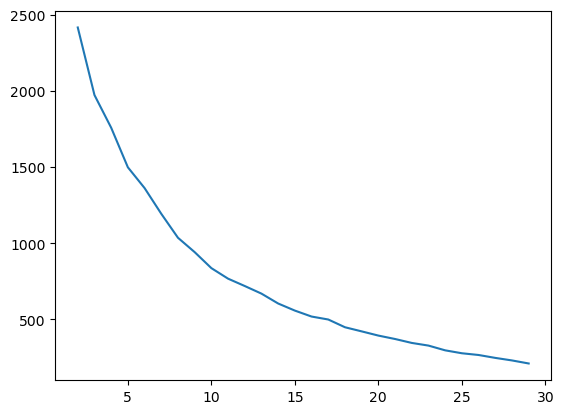

In [28]:
import seaborn as sns
from sklearn.cluster import DBSCAN

def visualize_inertia(cluster_lists, X_features):
    inertias = []
    for n_cluster in cluster_lists:
        k_means = KMeans(n_clusters = n_cluster, max_iter=500, random_state=42)
        k_means.fit(X_features)
        inertias.append(k_means.inertia_)
        
    sns.lineplot(x=cluster_lists, y=inertias)

visualize_inertia([i for i in range(2, 30)], meta_df.drop(['sales_mean'], axis=1))

In [37]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans,DBSCAN
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        # clusterer = DBSCAN(min_samples=10)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/smart01/.conda/envs/bonbak/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

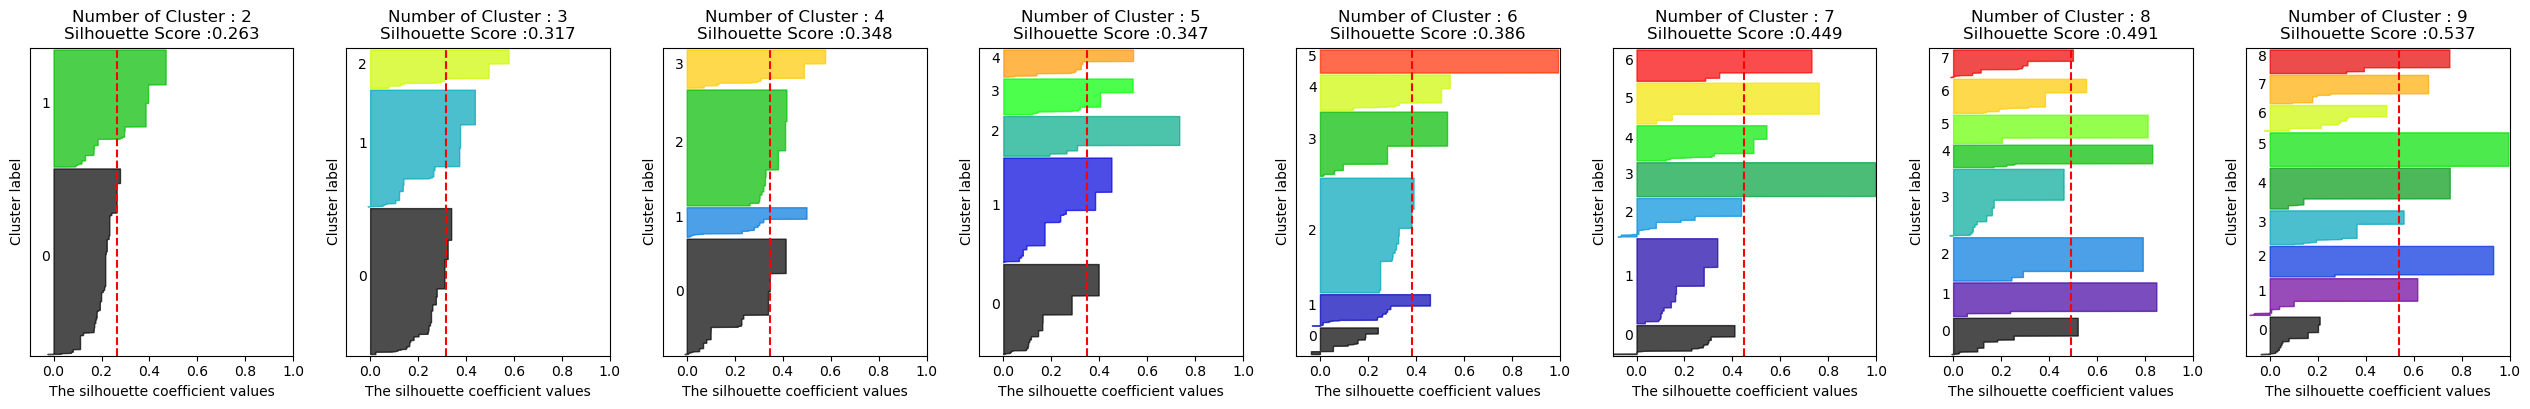

In [38]:
visualize_silhouette([i for i in range(2, 10)], meta_df.drop(['sales_mean'], axis=1))

In [44]:
from sklearn.cluster import KMeans,DBSCAN
clusterer = DBSCAN(min_samples=10)
cluster_labels = clusterer.fit_predict(meta_df.drop(['sales_mean'], axis=1))
np.unique(cluster_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([118, 187,  86,  48,  19, 173,  69,  16, 113,  21,  12,  12,  15,
         46,  11,  36,  11,  14,  13,  82,  15,  37, 204, 108, 138,  21,
         24,  32,  12,  37,  18,  23]))